# TensorFlow Quickstart for Beginners
Resources:
* [Quickstart Guide](https://www.tensorflow.org/tutorials/quickstart/beginner)

## Summary

Steps:
* Build a NN that classified images
* Train it
* Evaluate model accuracy

In [26]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [27]:
# import tensorflow
import tensorflow as tf

# load mnist dataset into test and train vars
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0 # convert from int to float

Inputs:
* We have 60,000 training samples and 10,000 test samples
* Features are comprised of 28x28 pixel images stored as floating point pixel values
* Targets are integer values from 0-9 where the output value corresponds to the written digit being analysed

In [28]:
x_train.shape

(60000, 28, 28)

In [29]:
x_test.shape

(10000, 28, 28)

## Keras Layer Types

Source: [Layer Types Explained](https://machinelearningknowledge.ai/different-types-of-keras-layers-explained-for-beginners/#:~:text=1%20Dense%20Layer.%20Dense%20Layer%20is%20a%20widely,...%208%20Pooling%20Layer.%20...%20More%20items...%20)

Notes:
* **Dense Layer:**
    * [Keras Docs](https://keras.io/api/layers/core_layers/dense/)
    * Standard ANN layer which computes the dot product of inputs and weights before adding a bias and applying an activation function
    * You can specify shape/# of nodes, activation functions and so on
* **Flatten Layer:**
    * This simply takes a multi-dimensional input (e.g. 3x3) and flattens it into a single dimensional output (e.g. 1x9)
* **Dropout Layer:**
    * [How To Use Dropout Layers](https://machinelearningknowledge.ai/keras-dropout-layer-explained-for-beginners/#:~:text=%20How%20to%20use%20Dropout%20Layer%20in%20Keras%3F,more%20input%20values%20will%20be%20dropped.%20More%20)
    * Reduces overfitting by dropping a specified % of nodes from the network (i.e. regularization)
    * It helps to remove noise from the input neurons
* **Reshape Layer:**
    * Simply changes the shape of the input data to the specified output dimensions
* **Permute Layer:**
    * Applies a pattern to alter the shape of the input
* **RepeatVector Layer:**
    * Simply repeats the input vector the specified number of times
    * e.g. repeating a 1x16 input 16 times results in a 16x16 output
* **Lambda Layer:**
    * Allows you to provide a custom function to transform your inputs
    * This can be anything you want and you can specify the desired output shape, make, arguments etc.
* **Pooling Layer:**
    * Allows you to apply max, average, sum etc. pooling
    * Reduces the input dimensions by a factor linked to the stride value you provide
* **Locally Connected Layer:**
    * Similar to 1D convolutional layers except that these do no share weights
    
## Building the Network
Steps:
* Create a sequential model that allows us to add layers as we choose
* Flatten the initial 28x28 input into a single, flat 1x784 input
* Dense layer with ReLU activation
* Dropout layer to remove 20% of the nodes
* Final dense layer with 10 outputs for classification

In [30]:
# ensure that all floats are handled as 64-bit (prevents later dtype inconsistencies)
tf.keras.backend.set_floatx('float64')

# build sequential model
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10) # you could use softmax here but the docs discourage it due to loss function stability (?)
])

## Predictions
Notes:
* Each training example returns log-odds scores for each class
* This allows us to identify which output our model has identified for each input
* Below you can see that the last class is the most likely but the third to last is also a contender
* Our model is untrained at this point though so the predictions are mostly random

In [31]:
# make predictions on the first training sample and examine
predictions = model(x_train[:1]).numpy()
predictions

array([[ 0.50223266,  0.09964019,  0.2052093 , -0.25357763, -0.34214682,
        -0.00222056,  0.59553801, -0.15264251,  0.13387654, -0.28319529]])

## Untrained Model
Notes:
* You can see above that our initial, untrained model has predicted the highest probability output classes as 7 and 9
* But when we visualize the image in question below, we can clearly see that it's a 5 (or perhaps a squished 3)
* This is simply due to our untrained model using essentially randomised weights, biases etc. and producing mostly random outputs

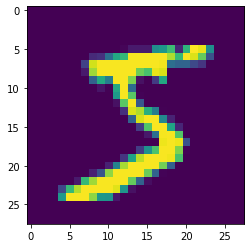

In [32]:
# load numpy and visualization library
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

# display image
t = (x_train[:1]*255)      # convert pixel values from normalized (0-1) to greyscale (0-255)
t = t.reshape(28, 28)      # reshape from (1, 28, 28) to (28, 28) otherwise pillow thinks it's a 1x28 image with 28 channels
image = Image.fromarray(t) # convert to pillow image object
#image.show()               # display in separate window
imshow(np.asarray(image))  # display in-line

## Loss Function
Notes:
* Here we use sparse categorical crossentropy
* It determines the loss/error between our actual and predicted outcomes
* It expects y_test target values to be integers of size n_classes
* We pass in y_pred which has a probability score for each of the possible n_classes
* It is used when we have 2+ output classes, we would instead use standard CategoricalCrossEntropy if we were performing one-hot encoding of our output classes
* [SCCE](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
* The untrained model gives close to random (1/10) probabilities for each class, meaning that our initial loss (below) is ~2.3 (negative log of the true class, 0 if the model is sure of the class)

In [33]:
# define loss function
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

# calculate error between y_pred and y_test
error = loss_fn(y_train[:1], predictions).numpy()
error

2.403571128845215

## Fit/Train Our Model
Notes:
* Fit the model by adjusting weights, biases and other parameters to minimize the loss
* Epochs are the number of runs through the training model (i.e. 1 epoch = 1 iteration over provided x and y data)
* Batch size is used to split up large datasets, for example if your dataset is 10,000 samples and you set a batch size of 100, it will pass blocks of 100 samples to your model to be processed. Once the entire dataset is processed (in however many batches it takes, e.g. 100 in this example) then the model updates its weights and can move onto the next epoch
    * [Batch Size Explained](https://androidkt.com/batch-size-step-iteration-epoch-neural-network/)
* Lots of other options here such as weighting particular classes, shuffling, validating data etc. 

In [35]:
# compile model with selected optimizer, loss function and metrics
model.compile(optimizer='adam',     # adaptive stochastic gradient descent
              loss=loss_fn,
              metrics=['accuracy'])

# fit model to training data
model.fit(x_train, y_train, epochs=5)

Train on 60000 samples
Epoch 1/5
60000/60000 [==============================] - 8s 129us/sample - loss: 0.2976 - accuracy: 0.9125
Epoch 2/5
60000/60000 [==============================] - 7s 114us/sample - loss: 0.1444 - accuracy: 0.9571
Epoch 3/5
60000/60000 [==============================] - 7s 115us/sample - loss: 0.1090 - accuracy: 0.9674
Epoch 4/5
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0879 - accuracy: 0.9723
Epoch 5/5
60000/60000 [==============================] - 7s 113us/sample - loss: 0.0765 - accuracy: 0.9755


## Model Evaluation
Notes:
* Validate the model on the test data
* Essentially check if the output of the trained model is close to the actual outputs in our known test data
* Below we see that the loss is small and the accuracy is high which is a good sign

In [36]:
# validate the model on the test data
model.evaluate(x_test, y_test, verbose=2)

10000/1 - 1s - loss: 0.0445 - accuracy: 0.9781


[0.07267672455775656, 0.9781]

## Outputting Probability
Notes:
* Above we were looking at the raw log odds
* However, we can use a softmax layer to output class probabilities
* Below we add a softmax layer to the end of our model
* This shows us that the 8th class (corresponding to "7") is the highest probability by far (99.997%)
* And when we visualize the image itself we can see that this is spot on

In [41]:
# wrap model and add a softmax output layer
probability_model = tf.keras.Sequential([
    model,
    tf.keras.layers.Softmax()
])

# run model on data, outputting probability instead of log-odds this time
probs = probability_model(x_test[:1])
probs

<tf.Tensor: id=30426, shape=(1, 10), dtype=float64, numpy=
array([[2.79358427e-08, 1.23374100e-09, 5.35448220e-06, 1.55470574e-05,
        5.46718690e-11, 1.09041789e-08, 3.98929383e-14, 9.99974092e-01,
        2.68011807e-08, 4.93949183e-06]])>

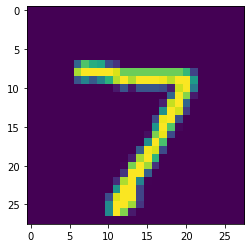

In [57]:
# display image
t = (x_test[:1]*255)
t = t.reshape(28, 28)
image = Image.fromarray(t)
imshow(np.asarray(image))